# Dissecting Spotify Valence

> *Practical Data Science*  
> *MSc in Data Science, Department of Informatics*  
> *Athens University of Economics and Business*

---

<p style='text-align: justify;'>Spotify is a Swedish audio streaming and media services provider founded on 23 April 2006 by Daniel Ek and Martin Lorentzon. It is one of the largest music streaming service providers, with over 422 million monthly active users, including 182 million paying subscribers, as of March 2022. Spotify is currently available in 180+ countries, as of October 2021. Users search for music based on artist, album or genre, and can create, edit and share playlists.</p>

<p style='text-align: justify;'>Spotify uses a metric called <b>valence</b> that describes the musical positiveness conveyed by a track. Tracks with high valence sound more positive (happy, cheerful, euphoric), while tracks with low valence sound more negative (sad, depressed, angry). The metric itself, however, was not developed by Spotify. It was developed by <a href="https://en.wikipedia.org/wiki/The_Echo_Nest" target="_blank">Echo Nest</a>, a company that was bought by Spotify in 2014. We don't know exactly how valence is calculated. Some details are given by <a href="https://web.archive.org/web/20170422195736/http://blog.echonest.com/post/66097438564/plotting-musics-emotional-valence-1950-2013" target="_blank">this</a> blog post.</p>

<p style='text-align: justify;'>Our aim in this project is to untangle the mystery behind valence and examine how it is derived. For this purpose we will download tracks and their audio features using the Spotify Web API. The audio features contain track information such as acousticness, danceability, duration, energy, instrumentalness, valence and many more. More details can be found <a href="https://developer.spotify.com/documentation/web-api/reference/#/operations/get-several-audio-features" target="_blank">here</a>. As a first step, we will try to understand the relationships between the different audio features. In addition, we will use inferential statistic methods to study how different audio features influence valence. Finally, based on the audio features, we will investigate whether we can successfully predict the valence of a song using machine learning.</p>

## *Table of Contents*

- [*1. Introduction*](#introduction)
    - [*1.1. Libraries*](#libraries)
    - [*1.2. Notebook Settings*](#notebook_settings)
    - [*1.3. Data Collection*](#data_collection)
- [*2. Data Cleansing*](#data_cleansing)
- [*3. Explore Which Track Features Influence Valence*](#explore_audio_features)
    - [*3.1. Pairwise Feature Correlation*](#pairwise_feature_correlation)
    - [*3.2. Feature Significance*](#feature_significance)
- [*4. Data Preprocessing*](#data_preprocessing)
    - [*4.1. One-Hot Encoding*](#ohe)
    - [*4.2. Train Test Split*](#train_test_split)
- [*5. Feature Engineering*](#feature_engineering)
    - [*5.1. Feature Scaling*](#feature_scaling)
- [*6. Modeling*](#modeling)
    - [*6.1. Cross Validation*](#cross_validation)
    - [*6.2. GridSearchCV*](#grid_search_cv)
    - [*6.3. Predictions (on test set)*](#preds_test_set)
    - [*6.4. Predictions (on a new random sample of track IDs)*](#preds_random_sample)
- [*7. Conclusion*](#conclusion)
    
---

## Introduction <a class='anchor' id='introduction'></a>

### *Libraries* <a class='anchor' id='libraries'></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import glob
import re
from datetime import datetime

import statsmodels.formula.api as smf
import scipy.stats.stats as stats
import statsmodels.api as sm
from scipy.stats import shapiro

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, KFold
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

import warnings
warnings.filterwarnings('ignore')

### *Notebook Settings* <a class='anchor' id='notebook_settings'></a>

In [2]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

### *Data Collection* <a class='anchor' id='data_collection'></a>

- In order to untangle the mystery behind valence, we need to collect and analyze data from *Spotify*
- Fortunately, *Spotify* has millions of playlists from which we can download tracks and audio features
- We will download tracks and audio features from the following public playlists available on the platform
    - [The Longest Playlist on Spotify (Official)](https://open.spotify.com/playlist/5S8SJdl1BDc0ugpkEvFsIL)
    - [The Longest Playlist Ever](https://open.spotify.com/playlist/6yPiKpy7evrwvZodByKvM9)
    - [Longest Playlist](https://open.spotify.com/playlist/5TnAhglHWtvU09tVMUYMUI)
    - [Biggest Playlist Ever](https://open.spotify.com/playlist/4rnleEAOdmFAbRcNCgZMpY)
    - [Biggest Playlist On Spotify (10.000+ Hours!)](https://open.spotify.com/playlist/0z085jfTrSXxhFUyKKExxJ)
    - [My Playlist: Rock, Metal, Rock n Roll](https://open.spotify.com/playlist/3WWv2APRYe9jR8L1YnK1Up)

##### *Dictionary with playlists to download*

In [3]:
playlist_dict = {'Top 10000 Songs Of All Time': ('Acclaimed Music', '1G8IpkZKobrIlXcVPoSIuf'),
                 'The Longest Playlist on Spotify (Official)': ('Willis Orr', '5S8SJdl1BDc0ugpkEvFsIL'),
                 'The Longest Playlist Ever': ('Oscar Lallier', '6yPiKpy7evrwvZodByKvM9'),
                 'Longest Playlist': ('Tuur Wondergem', '5TnAhglHWtvU09tVMUYMUI'),
                 'Biggest Playlist Ever': ('Susanna Ketola', '4rnleEAOdmFAbRcNCgZMpY'),
                 'Biggest Playlist On Spotify (10.000+ Hours!)': ('txcyr', '0z085jfTrSXxhFUyKKExxJ'),
                 'My Playlist: Rock, Metal, Rock n Roll': ('Jeremy Carver', '3WWv2APRYe9jR8L1YnK1Up')}

##### *Download tracks and their audio features*

In [4]:
from functions.spotify_master import download_playlists

# set starting time
start_time = datetime.now()

# download tracks and their audio features
spotify = download_playlists(playlist_dict)

# set ending time
end_time = datetime.now()

print(f'Wall time: {end_time - start_time}')

# drop duplicate ids
spotify.drop_duplicates(subset=['song_id'], inplace=True, ignore_index=True)

# save raw spotify data
spotify.to_csv('./data/raw_spotify_data.csv', index=False)

Client Authentication Successful!








Wall time: 1:52:53.536552


##### *Let's have a closer look at the data*

In [5]:
spotify.head()

,song_id,song_name,artist,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,playlist
0,3AhXZa8sUQht0UEdBJgpGc,Like a Rolling Stone,Bob Dylan,0.731000,0.482,369600,0.721,0,0,0.1890,-6.839,1,0.0321,95.263,4,0.557,Top 10000 Songs Of All Time
1,3oTlkzk1OtrhH8wBAduVEi,Smells Like Teen Spirit,Nirvana,0.000012,0.485,300977,0.863,0.0162,1,0.1380,-9.027,1,0.0495,116.835,4,0.767,Top 10000 Songs Of All Time
2,3ZFBeIyP41HhnALjxWy1pR,A Day In The Life - Remastered,The Beatles,0.290000,0.364,337413,0.457,0.000106,4,0.9220,-14.162,0,0.0675,163.219,4,0.175,Top 10000 Songs Of All Time
3,5Qt4Cc66g24QWwGP3YYV9y,Good Vibrations (Mono),The Beach Boys,0.082200,0.398,219147,0.413,0.000025,1,0.0891,-10.934,1,0.0388,133.574,4,0.331,Top 10000 Songs Of All Time
4,7MH2ZclofPlTrZOkPzZKhK,Johnny B Goode,Chuck Berry,0.735000,0.518,160893,0.756,0.000062,10,0.3170,-10.851,1,0.0915,166.429,4,0.968,Top 10000 Songs Of All Time


In [6]:
spotify.shape

(49662, 17)

In [7]:
spotify.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49662 entries, 0 to 49661
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   song_id           49662 non-null  object 
 1   song_name         49662 non-null  object 
 2   artist            49662 non-null  object 
 3   acousticness      49662 non-null  float64
 4   danceability      49662 non-null  float64
 5   duration_ms       49662 non-null  object 
 6   energy            49662 non-null  float64
 7   instrumentalness  49662 non-null  object 
 8   key               49662 non-null  object 
 9   liveness          49662 non-null  float64
 10  loudness          49662 non-null  float64
 11  mode              49662 non-null  object 
 12  speechiness       49662 non-null  float64
 13  tempo             49662 non-null  float64
 14  time_signature    49662 non-null  object 
 15  valence           49662 non-null  float64
 16  playlist          49662 non-null  object

- Some audio features have been downloaded having wrong data type
- Although they contain numeric data, they appear as an `object` type
- Therefore, we will change the type of these features and convert them to numerical

##### *Convert some of the audio features to numerical*

In [8]:
# features to ignore
to_ignore = spotify.columns[np.r_[0:3,16]]

# find object type features
obj_cols = spotify.drop(columns=to_ignore).select_dtypes(include=['object']).columns

# convert to numeric
for column in obj_cols:
    spotify[column] = pd.to_numeric(spotify[column])

##### *Descriptive Statistics*

In [9]:
spotify.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acousticness,49662.0,0.220845,0.288522,0.0,0.00598,0.073200,0.3480,0.996
danceability,49662.0,0.557983,0.175249,0.0,0.44000,0.564000,0.6860,0.988
duration_ms,49662.0,245681.412790,187151.925920,5307.0,189146.25000,222093.000000,265133.0000,6000661.000
energy,49662.0,0.675019,0.228865,0.0,0.52400,0.712000,0.8650,1.000
instrumentalness,49662.0,0.097015,0.235634,0.0,0.00000,0.000055,0.0142,0.999
key,49662.0,5.257883,3.577308,0.0,2.00000,5.000000,8.0000,11.000
liveness,49662.0,0.211181,0.188294,0.0,0.09710,0.133000,0.2700,0.999
loudness,49662.0,-7.552265,3.955556,-60.0,-9.20000,-6.574000,-4.9040,1.634
mode,49662.0,0.637993,0.480586,0.0,0.00000,1.000000,1.0000,1.000
speechiness,49662.0,0.087014,0.093312,0.0,0.03610,0.051300,0.0938,0.963


## Data Cleansing <a class='anchor' id='data_cleansing'></a>

- Before proceeding with the next steps, we need first clean up the data
- To keep the raw spotify data untouched in case we want to go back to it, we will create a copy and work on it

##### *Make a copy of raw spotify data*

In [10]:
df = spotify.copy() # copy of raw spotify data

##### *Check for duplicate track IDs*

In [11]:
# how many duplicate track IDs?
print(f'There are {df.duplicated(subset=["song_id"]).sum()} duplicates based on track ID.')

There are 0 duplicates based on track ID.


##### *Handle `duration_ms` values*

- According to [*Spotify*](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features), the `duration_ms` feature contains the duration of each track in milliseconds
- However, for better interpretability, we will convert the duration from milliseconds to seconds

##### *Convert track duration from milliseconds to seconds*

In [12]:
# milliseconds to seconds
df.duration_ms = df.duration_ms / 1000

# rename column
df = df.rename(columns={'duration_ms':'duration'})

##### *Handle `time_signature` values*

In [13]:
df.time_signature.value_counts().sort_index()

0       50
1      279
3     2794
4    45978
5      561
Name: time_signature, dtype: int64

- According to [*Spotify*](https://developer.spotify.com/documentation/web-api/reference/#/operations/get-audio-features), the `time_signature` feature ranges from 3 to 7 indicating time signatures of "3/4", to "7/4"
- However, Spotify extracts the audio features using machine learning models, which work quite well, but occasionally can get the values wrong
- Therefore, let's take a look at our data and drop any observations that contain invalid `time_signature` values

##### *Find rows with invalid `time_signature` values*

In [14]:
# valid time_signature values
valid_values = list(range(3,8))

# indices with invalid values
idx = df[~df.time_signature.isin(valid_values)].index

# how many rows with invalid values?
print(f'There are {df[df.index.isin(idx)].shape[0]} observations with invalid time_signature values.')

There are 329 observations with invalid time_signature values.


##### *Drop rows with invalid `time_signature` values*

In [15]:
# drop rows with invalid values
df.drop(labels=idx, inplace=True)

# reset index
df.reset_index(inplace=True, drop=True)

# shape
print(f'df.shape: {df.shape}')

df.shape: (49333, 17)


##### *Descriptive Statistics*

In [16]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acousticness,49333.0,0.219093,0.287012,0.00000,0.00593,0.072500,0.3430,0.996
danceability,49333.0,0.559308,0.174168,0.05850,0.44100,0.565000,0.6860,0.988
duration,49333.0,244.836081,175.623960,15.13300,189.30700,222.200000,265.1540,6000.295
energy,49333.0,0.676594,0.227560,0.00002,0.52600,0.714000,0.8660,1.000
instrumentalness,49333.0,0.096060,0.234184,0.00000,0.00000,0.000055,0.0139,0.999
key,49333.0,5.258792,3.577061,0.00000,2.00000,5.000000,8.0000,11.000
liveness,49333.0,0.210953,0.187952,0.00829,0.09710,0.133000,0.2700,0.999
loudness,49333.0,-7.510251,3.851932,-60.00000,-9.16400,-6.560000,-4.8980,1.634
mode,49333.0,0.637748,0.480656,0.00000,0.00000,1.000000,1.0000,1.000
speechiness,49333.0,0.086893,0.092648,0.02230,0.03610,0.051300,0.0937,0.963


## Explore Which Track Features Influence Valence <a class='anchor' id='explore_audio_features'></a>

- In this section we will try to understand the relationships between the different audio features
- In addition, we will use inferential statistic methods to study how different track features influence valence

##### *Make a copy of cleaned data*

In [17]:
dfs = df.copy() # copy of cleaned df

### *Pairwise Feature Correlation* <a class='anchor' id='pairwise_feature_correlation'></a>

- In statistics, the **Pearson Correlation Coefficient**, also known as **Pearson's r**, is a measure of *linear correlation* between two sets of data
- We will calculate **Pearson's r** to measure whether there is a *linear relationship* between any pair of features

##### *Calculate and plot pairwise feature correlation heatmap*

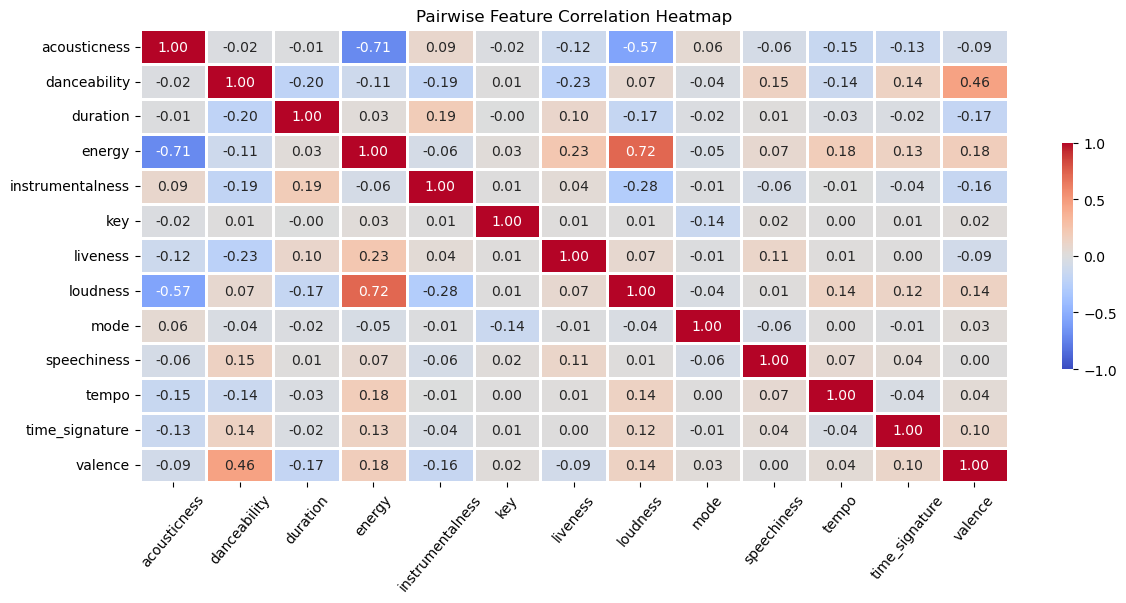

In [18]:
# calculate correlation
corr = dfs.corr(method='pearson')

# create figure
plt.figure(figsize=(14,6), dpi=100, facecolor='white')

# initialise plot settings
cmap = sns.color_palette("coolwarm", as_cmap=True)
ticks = [-1, -0.5, 0, 0.5, 1]

# plot the feature correlation heatmap
sns.heatmap(corr, annot=True, fmt='.2f', vmin=-1, cmap=cmap, linewidths=1.0, cbar_kws={'shrink': .5, 'ticks': ticks})

# params
plt.xticks(rotation=50)
plt.title('Pairwise Feature Correlation Heatmap')

plt.savefig('./images/pairwise_feature_correlation.svg')
plt.show()

- It appears that there are two pairs of strongly linearly correlated features
    - `acousticness` - `energy` have a strong *negative linear correlation*
    - `energy` - `loudness` have a strong *positive linear correlation*
- The rest of the pairs are either moderately or weakly linearly correlated

### *Feature Significance* <a class='anchor' id='feature_significance'></a>

- We will use regression to examine the relationship between the independent variables and the dependent variable
- In our case, `valence` is the dependent variable while the rest of the audio features are the independent ones
- Some of our data features are nominal, and thus we will convert them to dummy before proceeding with the regression

##### *Get dummy variables*

In [19]:
# nominal features
nominal = ['key', 'mode', 'time_signature']

# create dummy variables
dfs = pd.get_dummies(dfs, columns=nominal, drop_first=True)

In [20]:
dfs.head()

,song_id,song_name,artist,acousticness,danceability,duration,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,playlist,key_1,key_2,key_3,key_4,key_5,key_6,key_7,key_8,key_9,key_10,key_11,mode_1,time_signature_4,time_signature_5
0,3AhXZa8sUQht0UEdBJgpGc,Like a Rolling Stone,Bob Dylan,0.731000,0.482,369.600,0.721,0.000000,0.1890,-6.839,0.0321,95.263,0.557,Top 10000 Songs Of All Time,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,3oTlkzk1OtrhH8wBAduVEi,Smells Like Teen Spirit,Nirvana,0.000012,0.485,300.977,0.863,0.016200,0.1380,-9.027,0.0495,116.835,0.767,Top 10000 Songs Of All Time,1,0,0,0,0,0,0,0,0,0,0,1,1,0
2,3ZFBeIyP41HhnALjxWy1pR,A Day In The Life - Remastered,The Beatles,0.290000,0.364,337.413,0.457,0.000106,0.9220,-14.162,0.0675,163.219,0.175,Top 10000 Songs Of All Time,0,0,0,1,0,0,0,0,0,0,0,0,1,0
3,5Qt4Cc66g24QWwGP3YYV9y,Good Vibrations (Mono),The Beach Boys,0.082200,0.398,219.147,0.413,0.000025,0.0891,-10.934,0.0388,133.574,0.331,Top 10000 Songs Of All Time,1,0,0,0,0,0,0,0,0,0,0,1,1,0
4,7MH2ZclofPlTrZOkPzZKhK,Johnny B Goode,Chuck Berry,0.735000,0.518,160.893,0.756,0.000062,0.3170,-10.851,0.0915,166.429,0.968,Top 10000 Songs Of All Time,0,0,0,0,0,0,0,0,0,1,0,1,1,0


- For the linear regression model to run properly, all the features must be standardized
- However, we know that some of the features in our data are not standardized (e.g. `duration`)
- Thus, before we go ahead and run the model, we need to standardize them as well

##### *Standardize features*

In [21]:
# categorical features to ignore
to_ignore = ['song_id', 'song_name', 'artist', 'playlist']

# find which features to standardize
to_standardize = [feature for feature in dfs.drop(columns=to_ignore) if dfs[feature].max() > 1]

# features to standardize
print(f'Features to standardize: {to_standardize}')

# standardize features
dfs[to_standardize] = dfs[to_standardize].apply(stats.zscore)

Features to standardize: ['duration', 'loudness', 'tempo']


##### *Linear Regression Model*

*Hypothesis Testing*
- **Null Hypothesis - ($H0$):** There is a linear relationship between `feature_name` and `valence`
- **Alternative Hypothesis ($H1$):** There is no linear relationship between `feature_name` and `valence`

*Results*
- We **reject** the Null Hypothesis ($H0$) if p-value < 0.05
- Any feature with p-value < 0.05 is considered statistically significant

In [22]:
# define formula
formula = 'valence ~ ' + '+'.join(dfs.drop(columns=['song_id', 'song_name', 'artist', 'valence', 'playlist']))

# create and fit linear regression model
model = smf.ols(formula, data=dfs).fit()

# print results
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                valence   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     1021.
Date:                Wed, 08 Jun 2022   Prob (F-statistic):               0.00
Time:                        17:27:31   Log-Likelihood:                 9491.4
No. Observations:               49333   AIC:                        -1.893e+04
Df Residuals:                   49309   BIC:                        -1.872e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -0.3162      0.008  

##### *Get statistically significant features*

In [23]:
# get statistically significant features
stat_sig = [x for i, x in enumerate(model.params.index[1:]) if model.pvalues[i+1] <= 0.05]

# print stat sig features
for i, feature in enumerate(stat_sig):
    print(f'0{i+1}: {feature}' if i < 9 else f'{i+1}: {feature}')

01: acousticness
02: danceability
03: duration
04: energy
05: instrumentalness
06: liveness
07: loudness
08: speechiness
09: tempo
10: key_1
11: key_2
12: key_5
13: key_8
14: key_9
15: mode_1
16: time_signature_4
17: time_signature_5


## Data Preprocessing <a class='anchor' id='data_preprocessing'></a>

- Now it is time to use machine learning techniques to predict valence based on track features
- We will also try to optimize the hyperparameters as much as possible to get the best possible results

##### *Create a copy of the cleaned data*

In [24]:
dfv = df.copy() # copy of cleaned df

In [25]:
dfv.head()

,song_id,song_name,artist,acousticness,danceability,duration,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,playlist
0,3AhXZa8sUQht0UEdBJgpGc,Like a Rolling Stone,Bob Dylan,0.731000,0.482,369.600,0.721,0.000000,0,0.1890,-6.839,1,0.0321,95.263,4,0.557,Top 10000 Songs Of All Time
1,3oTlkzk1OtrhH8wBAduVEi,Smells Like Teen Spirit,Nirvana,0.000012,0.485,300.977,0.863,0.016200,1,0.1380,-9.027,1,0.0495,116.835,4,0.767,Top 10000 Songs Of All Time
2,3ZFBeIyP41HhnALjxWy1pR,A Day In The Life - Remastered,The Beatles,0.290000,0.364,337.413,0.457,0.000106,4,0.9220,-14.162,0,0.0675,163.219,4,0.175,Top 10000 Songs Of All Time
3,5Qt4Cc66g24QWwGP3YYV9y,Good Vibrations (Mono),The Beach Boys,0.082200,0.398,219.147,0.413,0.000025,1,0.0891,-10.934,1,0.0388,133.574,4,0.331,Top 10000 Songs Of All Time
4,7MH2ZclofPlTrZOkPzZKhK,Johnny B Goode,Chuck Berry,0.735000,0.518,160.893,0.756,0.000062,10,0.3170,-10.851,1,0.0915,166.429,4,0.968,Top 10000 Songs Of All Time


##### *Descriptive Statistics*

In [26]:
dfv.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
acousticness,49333.0,0.219093,0.287012,0.00000,0.00593,0.072500,0.3430,0.996
danceability,49333.0,0.559308,0.174168,0.05850,0.44100,0.565000,0.6860,0.988
duration,49333.0,244.836081,175.623960,15.13300,189.30700,222.200000,265.1540,6000.295
energy,49333.0,0.676594,0.227560,0.00002,0.52600,0.714000,0.8660,1.000
instrumentalness,49333.0,0.096060,0.234184,0.00000,0.00000,0.000055,0.0139,0.999
key,49333.0,5.258792,3.577061,0.00000,2.00000,5.000000,8.0000,11.000
liveness,49333.0,0.210953,0.187952,0.00829,0.09710,0.133000,0.2700,0.999
loudness,49333.0,-7.510251,3.851932,-60.00000,-9.16400,-6.560000,-4.8980,1.634
mode,49333.0,0.637748,0.480656,0.00000,0.00000,1.000000,1.0000,1.000
speechiness,49333.0,0.086893,0.092648,0.02230,0.03610,0.051300,0.0937,0.963


### *One-Hot Encoding* <a class='anchor' id='ohe'></a>

- As we mentioned earlier, some of our data features are nominal
- Therefore, for those features, we will create dummy variables

##### *Get dummy variables*

In [27]:
# get dummy variables
dfv = pd.get_dummies(dfv, columns=['key', 'mode', 'time_signature'], drop_first=False)

# drop unwanted columns
dfv = dfv.drop(columns=['song_id', 'song_name', 'artist', 'playlist'])

In [28]:
dfv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49333 entries, 0 to 49332
Data columns (total 27 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   acousticness      49333 non-null  float64
 1   danceability      49333 non-null  float64
 2   duration          49333 non-null  float64
 3   energy            49333 non-null  float64
 4   instrumentalness  49333 non-null  float64
 5   liveness          49333 non-null  float64
 6   loudness          49333 non-null  float64
 7   speechiness       49333 non-null  float64
 8   tempo             49333 non-null  float64
 9   valence           49333 non-null  float64
 10  key_0             49333 non-null  uint8  
 11  key_1             49333 non-null  uint8  
 12  key_2             49333 non-null  uint8  
 13  key_3             49333 non-null  uint8  
 14  key_4             49333 non-null  uint8  
 15  key_5             49333 non-null  uint8  
 16  key_6             49333 non-null  uint8 

- According to the descriptive statistics, there is a huge variation in the `duration` value of the songs
- To better understand the case, let's plot the `duration` distribution

##### *Plot `duration` distribution*

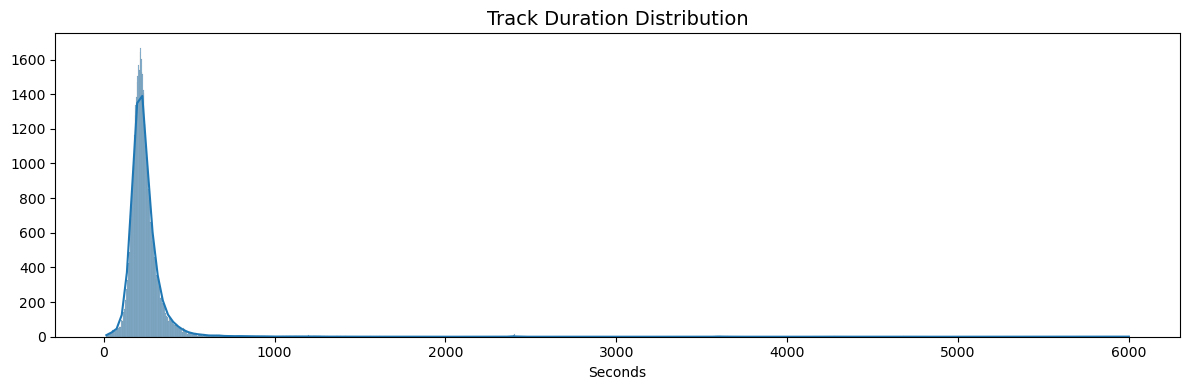

In [29]:
# create figure
plt.figure(figsize=(12,4), dpi=100)
    
# plot histogram
sns.histplot(dfv.duration, kde=True)
    
# params
plt.xlabel('Seconds')
plt.ylabel(None)
plt.title('Track Duration Distribution', fontsize=14)
    
plt.tight_layout()
plt.show()

- According to the graph, `duration` values range from almost 0 minutes to 100 minutes
- However, we don't want to take into account tracks with very short duration, loop tracks or long playlists nested in a single track
- Therefore, we will assume that the duration of a normal song can vary between *1 minute* and *15 minutes*
    - ***1min***: to include songs with duration betweem 1 minute and 2 minutes
    - ***15min***: to include songs with a longer duration but in a range that makes sense (e.g. trap songs, re-mastered songs, ambient music etc.)
    
##### *Keep tracks with 1min < `duration` < 15min*

In [30]:
# keep tracks with 1min < duration < 15min
dfv = dfv[(dfv.duration > 60) & (dfv.duration < 900)]

# shape
print(f'dfv.shape: {dfv.shape}')

dfv.shape: (48834, 27)


### *Train Test Split* <a class='anchor' id='train_test_split'></a>

In [31]:
# define features and target variable
x = dfv.drop(columns='valence')
y = dfv.valence

# train test split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1)

## Feature Engineering <a class='anchor' id='feature_engineering'></a>

### *Feature Scaling* <a class='anchor' id='feature_scaling'></a>

- Some machine learning algorithms will not work properly if the range of values of the data varies widely
- *Feature Scaling* is a method used to normalize the range of independent variables of the data
- Most of the features in our dataset are already normalized, but for those that are not we need to apply normalization

##### *Get features that need scaling*

In [32]:
# get the features that need scaling
to_scale = [feature for feature in x_train.columns if (dfv[feature].max() > 1)]

# features to scale
print(f'Features to scale: {to_scale}')

Features to scale: ['duration', 'loudness', 'tempo']


- Now that we have obtained the features, we need to decide which technique to use to scale them
- To understand this better, let's take a look at their distributions
- Depending on whether or not they follow a normal distribution, we will choose the appropriate scaler

##### *Create a function to visualize the distribution of non-normalized features*

In [33]:
def plot_distribution(df, i, feature):
    """
    1. Calculate feature skewness
    2. Run Shapiro Wilk test on a sample to test normality hypothesis
    3. Plot feature distribution
    """
    
    # calculate skewnees
    skewness = df[feature].skew()
    
    # select a sample of 1000 data points
    sample = df[feature].sample(n=1000, random_state=1)
    
    # test for normal distribution
    shapiro_wilk = shapiro(sample)
    norm_distrib = ('True' if shapiro_wilk.pvalue > 0.05 else 'False')
    
    # print results
    print(f'# {i+1} - {feature.capitalize()}')
    print('='*107)
    print(f'Skewness: {skewness}')
    print('-'*107)
    print(f'Shapiro Wilk test: {shapiro_wilk}')
    print('-'*107)
    print(f'Normal Distribution: {norm_distrib}')
    print('='*107)
    
    # create figure
    plt.figure(figsize=(12,4), dpi=100)
    
    # plot histogram
    sns.histplot(df[feature], kde=True)
    
    # params
    plt.xlabel(None)
    plt.ylabel(None)
    plt.title(f'{feature.capitalize()} Distribution', fontsize=14)
    
    plt.tight_layout()
    plt.show()
    
    return None

##### *Shapiro-Wilk Normality Test*

- We will use Shapiro-Wilk test to detect whether the population of features under consideration is normally distributed.

*Hypothesis Testing*
- **Null Hypothesis (H0):** The sample (obtained from `feature_name`) comes from a normal distribution
- **Alternative Hypothesis (H1):** The sample (obtained from `feature_name`) does not come from a normal distribution

*Results*
- We **reject** the Null Hypothesis (H0) if p-value < 0.05

# 1 - Duration
Skewness: 2.2583878333697887
-----------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9030863046646118, pvalue=1.1543243853918022e-24)
-----------------------------------------------------------------------------------------------------------
Normal Distribution: False


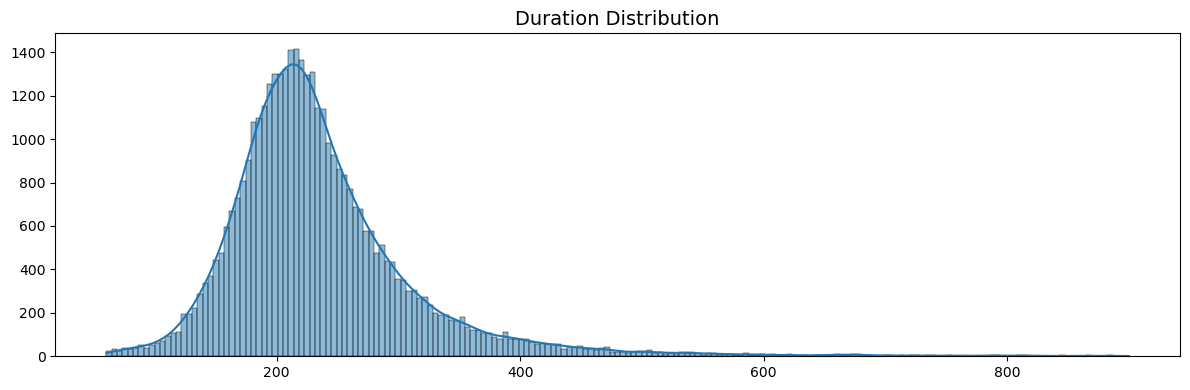

# 2 - Loudness
Skewness: -1.6317042560717814
-----------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.8999201059341431, pvalue=5.075449712911139e-25)
-----------------------------------------------------------------------------------------------------------
Normal Distribution: False


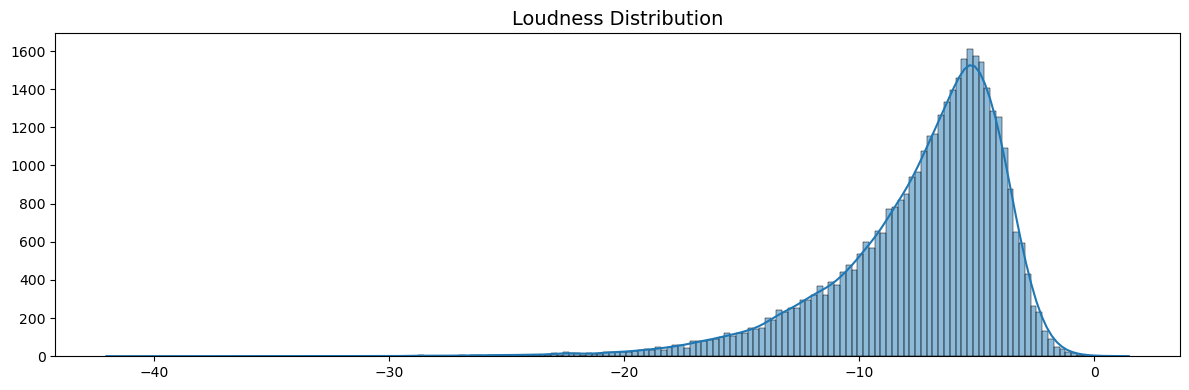

# 3 - Tempo
Skewness: 0.37799597311885613
-----------------------------------------------------------------------------------------------------------
Shapiro Wilk test: ShapiroResult(statistic=0.9886689782142639, pvalue=5.576281409958028e-07)
-----------------------------------------------------------------------------------------------------------
Normal Distribution: False


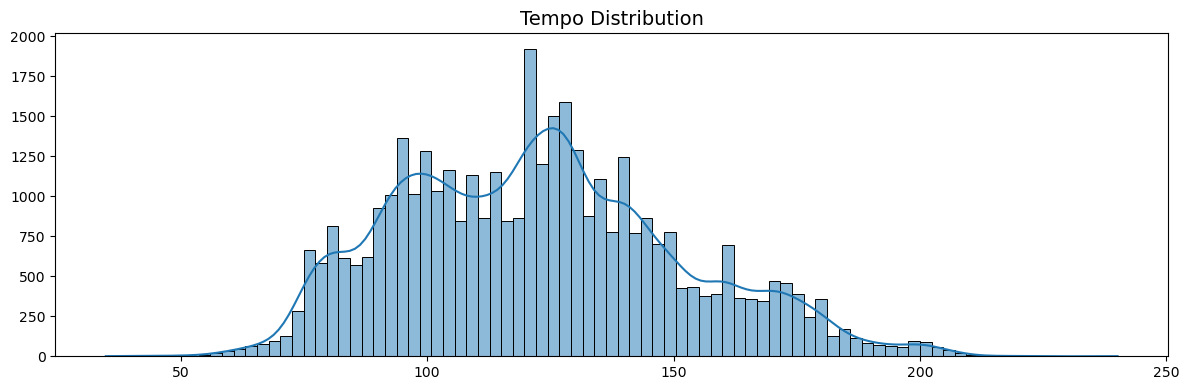

In [34]:
_ = [plot_distribution(x_train, i, feature) for i, feature in enumerate(to_scale)]

- According to the graphs, none of the features seem to follow a normal distribution
- Furthermore, the *p-value* obtained from the Shapiro-Wilk test is less than 5%, indicating that none of the samples tested come from a normal distribution
- Therefore, we ***reject*** the null hypothesis
- As a result of the previous test, we will scale these features using `MinMaxScaler`

##### *Scale using `MinMaxScaler`*

In [35]:
# initialise scaler
mms = MinMaxScaler()

# scale train and test set
x_train[to_scale] = mms.fit_transform(x_train[to_scale])
x_test[to_scale] = mms.transform(x_test[to_scale])

## Modeling <a class='anchor' id='modeling'></a>

### *Cross Validation* <a class='anchor' id='cross_validation'></a>

##### *Function to cross validate multiple models*

In [36]:
def cross_validate_models(x_train, y_train):
   
    # list of regressors
    models = [['LinearRegression', LinearRegression()],
              ['SVR', SVR()],
              ['RandomForest', RandomForestRegressor(random_state=1)],
              ['ExtraTrees', ExtraTreesRegressor(random_state=1)],
              ['XGBoost', XGBRegressor(verbosity=0, random_state=1)],
              ['LightGBM', LGBMRegressor(random_state=1)]]

    # create a dataframe to store the results
    cv_scores = pd.DataFrame(np.nan, index=[model[0] for model in models], columns=['MAE', 'RMSE', 'MSE', 'R2'])
    
    # loop through regressors
    for name, model in models:
        
        # cross validate
        scoring = ['neg_mean_absolute_error', 'neg_root_mean_squared_error', 'neg_mean_squared_error', 'r2']
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        scores = cross_validate(model, x_train, y_train, scoring=scoring, cv=cv)
        
        # evaluate
        avg_mae = abs(scores['test_neg_mean_absolute_error'].mean())
        avg_rmse = abs(scores['test_neg_root_mean_squared_error'].mean())
        avg_mse = abs(scores['test_neg_mean_squared_error'].mean())
        avg_r2 = scores['test_r2'].mean()
        
        # print results
        # print('='*30)
        # print(name)
        # print('-'*30)
        # print(f'MAE:  {avg_mae}')
        # print(f'RMSE: {avg_rmse}')
        # print(f'MSE:  {avg_mse}')
        # print(f'R2:   {avg_r2}', end='\n\n')
        
        # store the results
        cv_scores.loc[name, 'MAE'] = avg_mae
        cv_scores.loc[name, 'RMSE'] = avg_rmse
        cv_scores.loc[name, 'MSE'] = avg_mse
        cv_scores.loc[name, 'R2'] = avg_r2

    return cv_scores

# set starting time
start_time = datetime.now()

# run function to get the results
cv_scores = cross_validate_models(x_train, y_train)

# set ending time
end_time = datetime.now()

print(f'Wall time: {end_time - start_time}')

Running time: 0:07:39.755782


In [37]:
# print results
print(cv_scores.sort_values(by='MAE'))

                       MAE      RMSE       MSE        R2
ExtraTrees        0.133764  0.173827  0.030218  0.478523
RandomForest      0.137157  0.174174  0.030339  0.476426
XGBoost           0.142855  0.179065  0.032067  0.446582
LightGBM          0.142955  0.178003  0.031688  0.453140
SVR               0.152576  0.189093  0.035757  0.382899
LinearRegression  0.161362  0.197371  0.038956  0.327703


- Ensemble and Boosting Regressors seem to perform better
- Therefore, we will proceed to hyperparameter tuning with `ExtraTrees`, `RandomForest`, `LightGBM`

### *GridSearchCV* <a class='anchor' id='grid_search_cv'></a>

##### *Function to find the best hyperparameters*

In [38]:
def grid_search_tune_models(x_train, y_train):
    
    # list of regressors
    models = [['RandomForest', RandomForestRegressor(random_state=1)],
              ['ExtraTrees', ExtraTreesRegressor(random_state=1)],
              ['LightGBM', LGBMRegressor(random_state=1)]]
    
    # dict with hyperparameters
    param_grid = [{'n_estimators': range(100,600,200)},
                  {'n_estimators': range(100,600,200)},
                  {'n_estimators': range(100,600,200)}]

    # create a dataframe to store the results
    grid_scores = pd.DataFrame(np.nan, index=[model[0] for model in models], columns=['MAE', 'Best Estimator'])

    # grid search cv
    for i, (name, model) in enumerate(models):
        
        # gridsearchCV
        cv = KFold(n_splits=5, shuffle=True, random_state=1)
        grid = GridSearchCV(model, param_grid[i], scoring='neg_mean_absolute_error', cv=cv, n_jobs=-1)
        grid.fit(x_train, y_train)
        
        # evaluate
        best_score = abs(grid.best_score_)
        best_params = grid.best_params_
        best_estimator = grid.best_estimator_
        
        # print results
        print('='*73)
        print(f'{name}')
        print('-'*73)
        print(f'Best grid score: {best_score}')
        print(f'Best grid params: {best_params}')
        print(f'Best estimator: {best_estimator}', end='\n\n')
        
        # store the results
        grid_scores.loc[name, 'MAE'] = best_score

    return grid_scores

# set starting time
start_time = datetime.now()

# return best estimators
grid_scores = grid_search_tune_models(x_train, y_train)

# set ending time
end_time = datetime.now()

print(f'Wall time: {end_time - start_time}')

RandomForest
-------------------------------------------------------------------------
Best grid score: 0.13659822919265235
Best grid params: {'n_estimators': 500}
Best estimator: RandomForestRegressor(n_estimators=500, random_state=1)

ExtraTrees
-------------------------------------------------------------------------
Best grid score: 0.13321023274261518
Best grid params: {'n_estimators': 500}
Best estimator: ExtraTreesRegressor(n_estimators=500, random_state=1)

LightGBM
-------------------------------------------------------------------------
Best grid score: 0.13929840251477393
Best grid params: {'n_estimators': 500}
Best estimator: LGBMRegressor(n_estimators=500, random_state=1)

Running time: 0:09:34.219884


### *Predictions (on test set)* <a class='anchor' id='preds_test_set'></a>

##### *Function to make predictions on test set*

RandomForestRegressor(n_estimators=500, random_state=1)
-----------------------------------------------------------------------------------------------------------
MAE:  0.1359818038619618
RMSE: 0.17283273393436044
MSE:  0.02987115391922543
R2:   0.49628480241629336
-----------------------------------------------------------------------------------------------------------


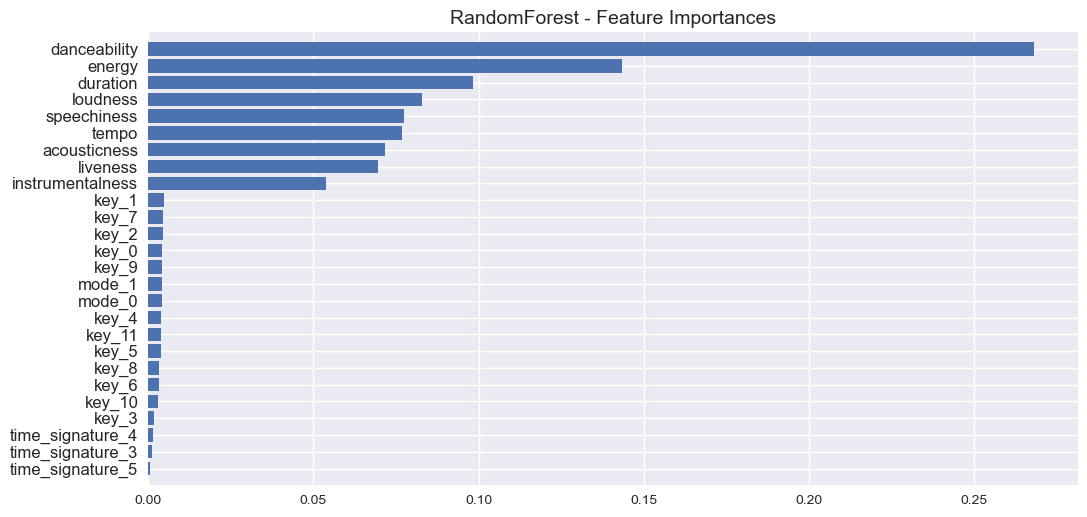

ExtraTreesRegressor(n_estimators=500, random_state=1)
-----------------------------------------------------------------------------------------------------------
MAE:  0.13178515819868966
RMSE: 0.17179060232027063
MSE:  0.02951201104556137
R2:   0.5023410037956462
-----------------------------------------------------------------------------------------------------------


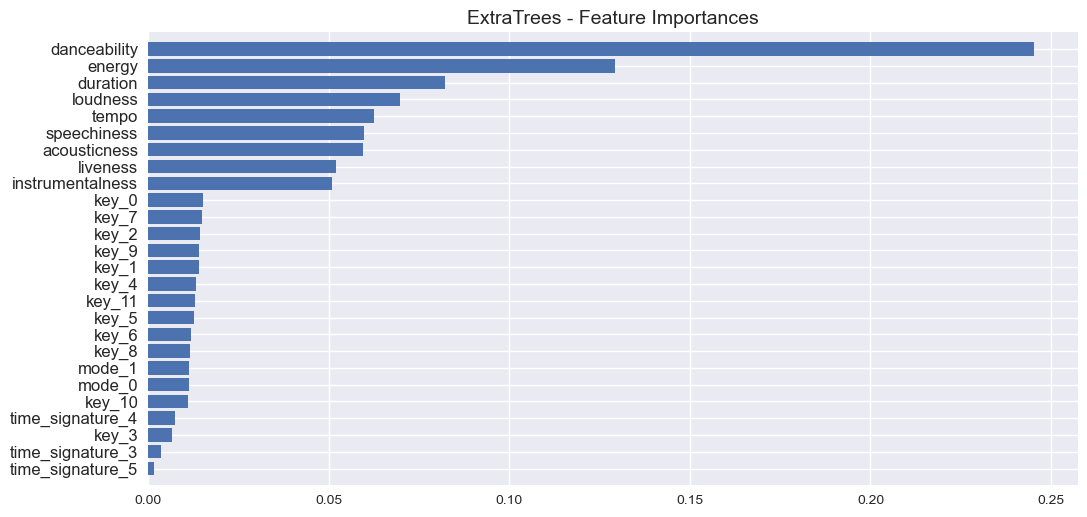

LGBMRegressor(n_estimators=500, random_state=1)
-----------------------------------------------------------------------------------------------------------
MAE:  0.13991309284621842
RMSE: 0.17569491858196423
MSE:  0.030868704415523036
R2:   0.4794631775570384
-----------------------------------------------------------------------------------------------------------


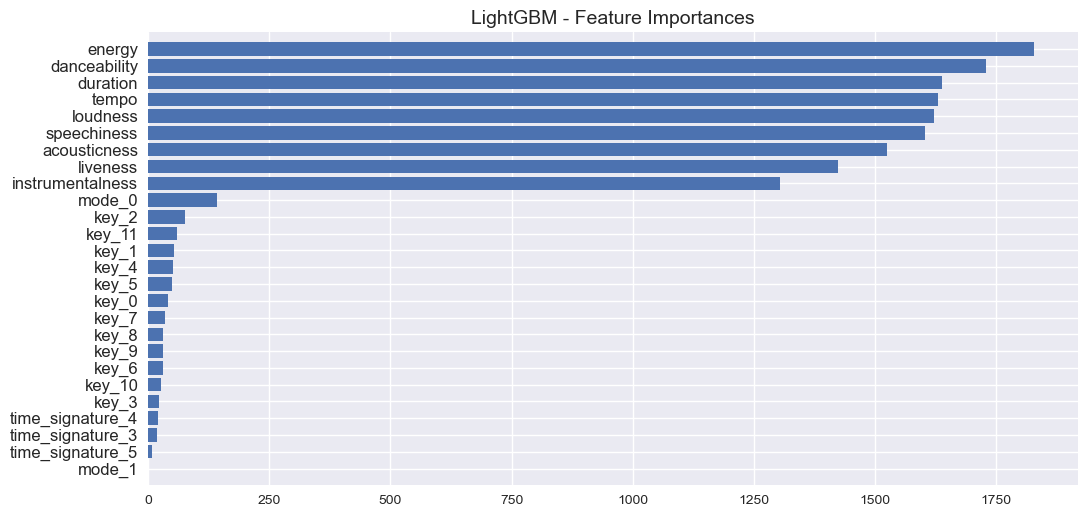

In [39]:
# function to make predictions
def make_predictions(x_train, x_test, y_train, y_test):
    
    # list of the best performing regressors
    models = [['RandomForest', RandomForestRegressor(n_estimators=500, random_state=1)],
              ['ExtraTrees', ExtraTreesRegressor(n_estimators=500, random_state=1)],
              ['LightGBM', LGBMRegressor(n_estimators=500, random_state=1)]]
    
    # create a dataframe to store the results
    pred_scores = pd.DataFrame(np.nan, index=[model[0] for model in models], columns=['MAE', 'RMSE', 'MSE', 'R2'])
    
    # loop through regressors
    for i, (name, model) in enumerate(models):
    
        # fit and predict
        model.fit(x_train, y_train)
        preds = model.predict(x_test)
    
        # evaluate
        mae = mean_absolute_error(y_test, preds)
        rmse = np.sqrt(mean_squared_error(y_test, preds))
        mse = mean_squared_error(y_test, preds)
        r2 = r2_score(y_test, preds)
        
        # print results
        print('='*107)
        print(f'{model}')
        print('-'*107)
        print(f'MAE:  {mae}')
        print(f'RMSE: {rmse}')
        print(f'MSE:  {mse}')
        print(f'R2:   {r2}')
        print('-'*107)
        
        # store results
        pred_scores.loc[name, 'MAE'] = mae
        pred_scores.loc[name, 'RMSE'] = rmse
        pred_scores.loc[name, 'MSE'] = mse
        pred_scores.loc[name, 'R2'] = r2
        
        # calculate feature importances
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]
    
        # function to plot feature importances
        def plot_importances(x_train, importances, indices):
            plt.style.use('seaborn')
            plt.figure(figsize=(12,6), dpi=100, facecolor='white')
            plt.title(f'{models[i][0]} - Feature Importances', fontsize=14)
            plt.barh(range(x_train.shape[1]), importances[indices], tick_label=[x_train.columns.values.tolist()[x] for x in indices])  
            plt.ylim([-1, x_train.shape[1]])
            plt.yticks(size=12)
            plt.gca().invert_yaxis()
            plt.savefig(f'./images/{models[i][0]}_feature_importances.svg')
            plt.show()
            return None
        
        plot_importances(x_train, importances, indices)
    
    return pred_scores
        
predictions = make_predictions(x_train, x_test, y_train, y_test)

In [40]:
# print results
print(predictions.sort_values(by='MAE'))

                   MAE      RMSE       MSE        R2
ExtraTrees    0.131785  0.171791  0.029512  0.502341
RandomForest  0.135982  0.172833  0.029871  0.496285
LightGBM      0.139913  0.175695  0.030869  0.479463


##### *Best performing model*

In [41]:
best_model = predictions.sort_values(by="MAE").index[0]
best_score = predictions.sort_values(by="MAE").iloc[0,0]

print(f'The best performing model is {best_model}, with MAE = {best_score}.')

The best performing model is ExtraTrees, with MAE = 0.13178515819868966.


### *Predictions (on a new random sample of track IDs)* <a class='anchor' id='preds_random_sample'></a>

- Let's test our model on a sample of Spotify's top-streaming charts around the world
- Top-streaming charts are provided by [Spotify Charts](https://spotifycharts.com)
- Unfortunately, although the data are downloadble in csv format, we cannot scrape them as access to them is guarded by CloudFare
- Fortunately, data for some countries and the world as a whole, for the period 2017-2019, is available in [Zenodo](https://zenodo.org/record/4778563)

> *Gabriel P. Oliveira, Mariana O. Silva, Danilo B. Seufitelli, Anisio Lacerda, and Mirella M. Moro. Detecting Collaboration Profiles in Success-based Music Genre Networks. In Proceedings of the 21st International Society for Music Information Retrieval Conference (ISMIR 2020), 2020.*

##### *Read top streaming charts data downloaded from Zenodo*

In [42]:
header = 0
dfs = []
for file in glob.glob('./data/charts/*/201?/*.csv', recursive = True):
    # get country
    region = file.split('/')[2]
    # get date
    dates = re.findall('\d{4}-\d{2}-\d{2}', file.split('/')[-1])
    # read the csv
    weekly_chart = pd.read_csv(file, header=header, sep='\t')
    # set the week start date
    weekly_chart['week_start'] = datetime.strptime(dates[0], '%Y-%m-%d')
    # set the week end date
    weekly_chart['week_end'] = datetime.strptime(dates[1], '%Y-%m-%d')
    # set the region
    weekly_chart['region'] = region
    # append data in each iteration
    dfs.append(weekly_chart)

charts = pd.concat(dfs)
charts.head()

,position,song_id,song_name,artist,streams,last_week_position,weeks_on_chart,peak_position,position_status,week_start,week_end,region
0,1,7wGoVu4Dady5GV0Sv4UIsx,rockstar,Post Malone,17532665,1.0,3,1,0,2017-10-20,2017-10-27,charts
1,2,75ZvA4QfFiZvzhj2xkaWAh,I Fall Apart,Post Malone,8350785,2.0,6,2,0,2017-10-20,2017-10-27,charts
2,3,2fQrGHiQOvpL9UgPvtYy6G,Bank Account,21 Savage,7589124,4.0,5,3,1,2017-10-20,2017-10-27,charts
3,4,43ZyHQITOjhciSUUNPVRHc,Gucci Gang,Lil Pump,7584237,5.0,3,4,1,2017-10-20,2017-10-27,charts
4,5,5tz69p7tJuGPeMGwNTxYuV,1-800-273-8255,Logic,7527770,3.0,26,1,-2,2017-10-20,2017-10-27,charts


In [43]:
charts.shape

(273600, 12)

- Now that we obtained the top-streaming charts from Zenodo, we need to get their audio features as well
- To do so, we first need to get their track IDs
- We will randomly select a sample of 2000 tracks and get their IDs
- Once we have their IDs, we can then download their audio features using the Spotify Web API

##### *Get a random sample of 2000 tracks*

In [44]:
# get a sample
random_sample_ids = charts.song_id.sample(n=2000, random_state=13)

##### *Download audio features for the randomly selected track IDs*

In [45]:
from functions.spotify_master import download_track_features_with_ids

# set starting time
start_time = datetime.now()

# download audio features
provided_tracks = download_track_features_with_ids(random_sample_ids)

# set ending time
end_time = datetime.now()

print(f'Wall time: {end_time - start_time}')

Client Authentication Successful!

Getting audio features...
Getting audio features... Done!

Wall time: 0:03:39.535162


##### *Clean and preprocess train and test set*

In [46]:
from functions.prepare_data_master import clean_and_preprocess_data

# clean and preprocess data
train_set, test_set = clean_and_preprocess_data(spotify, provided_tracks)

# shapes
print(f'train_set.shape: {train_set.shape} - test_set.shape: {test_set.shape}')

Cleaning train data...
Preprocessing train data...
Cleaning and preprocessing train data is done!

Cleaning test data...
Preprocessing test data...
Cleaning and preprocessing test data is done!

train_set.shape: (48834, 28) - test_set.shape: (1384, 28)


##### *Scale train and test set*

In [47]:
# features to scale
to_scale = ['duration', 'loudness', 'tempo']

# initialise scaler
mms = MinMaxScaler()

# scale train and test set
train_set[to_scale] = mms.fit_transform(train_set[to_scale])
test_set[to_scale] = mms.transform(test_set[to_scale])

##### *Make predictions*

In [48]:
# initialise model
model = ExtraTreesRegressor(n_estimators=500, random_state=1)

# fit the model
model.fit(train_set.drop(columns=['song_id', 'valence']), train_set.valence)

# make predictions
preds = model.predict(test_set.drop(columns=['song_id', 'valence']))

# calculate metrics
mae = mean_absolute_error(test_set.valence, preds)
rmse = np.sqrt(mean_squared_error(test_set.valence, preds))
mse = mean_squared_error(test_set.valence, preds)
r2 = r2_score(test_set.valence, preds)

# print results
print(f'MAE:  {mae}')
print(f'RMSE: {rmse}')
print(f'MSE:  {mse}')
print(f'R2:   {r2}')

MAE:  0.07268377817919208
RMSE: 0.12682848665358656
MSE:  0.016085465026838986
R2:   0.6508371369515882


## Conclusion <a class='anchor' id='conclusion'></a>

<p style='text-align: justify;'>Combining the results obtained from the statistical analysis on the most significant features and the feature importances retrieved from the regressors, we could conclude that the features that most influence the valence metric are <b><i>danceability</i></b>, <b><i>energy</i></b> and <b><i>duration</i></b>. This is something we might expect. In fact it makes perfect sense, since during happy and euphoric songs we tend to spend more energy dancing. Furthermore, the best performing regressor seemed to be <b><i>ExtraTrees</i></b> yielding a <b><i>Mean Absolute Error</i></b> of approx. <b><i>0.132</i></b> on the test and approx. <b><i>0.073</i></b> on the random sample of Spotify's top-streaming charts.</p>

---

*Thank you!*

---